---

Universidade Federal do Rio Grande do Norte

Centro de Tecnologia

Departamento de Engenharia de Computação e Automação

ELE0606 - Tópicos especiais em inteligência artificial

Student: Levy Gabriel da Silva Galvão

Título: Clustering validation indexes

---

# Libraries

In [1]:
!pip install hdbscan &> /dev/null # install HDBSCAN
!pip install git+https://github.com/alashkov83/DBCV &> /dev/null # install DBCV
!curl https://raw.githubusercontent.com/jqmviegas/jqm_cvi/master/jqmcvi/base.py -o jqmcvi_base.py &> /dev/null # install Dunn
!pip install --upgrade cdbw &> /dev/null # install CDbw
#!git clone https://github.com/Simon-Bertrand/Clusters-Features ClustersFeatures &> /dev/null # install PBM
!sudo apt-get install subversion &> /dev/null
!svn checkout https://github.com/Simon-Bertrand/Clusters-Features/trunk/ClustersFeatures &> /dev/null # install PBM
!pip uninstall umap &> /dev/null
!pip install umap-learn &> /dev/null

In [2]:
# Data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from google.colab import files

sns.set_theme();

# Utility
import umap.umap_ as umap
import scipy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Simulated datasets
from sklearn.datasets import make_blobs, \
                             make_moons, \
                             make_circles

# CVIs
from sklearn.metrics import calinski_harabasz_score # CH
from sklearn.metrics import davies_bouldin_score # DB
from ClustersFeatures import * # PBM
from cdbw import CDbw # CDbw
from jqmcvi_base import dunn_fast # Dunn 
from DBCV import DBCV # DBCV

# Clustering
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans, \
                            DBSCAN

# Functions

Dimensionality reduction:

- Principal component analysis ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA))

In [3]:
def pca_plot(X, y, title=""):
  target_names = np.unique(y)
  pca = PCA(n_components=2)
  X2D = pca.fit(X).transform(X) # feature matrix after pca

  print('Explained variance ratio: %s' % str(pca.explained_variance_ratio_))
  plt.figure(figsize=(5,5))
  for target_name in target_names:
    plt.scatter(
        x=X2D[y==target_name, 0], y=X2D[y==target_name, 1], c=[np.random.rand(3,)], label=target_name
    )
  if(y[0]!='_nolegend_'):plt.legend(loc='best', shadow=False, scatterpoints=1)
  plt.title(title)
  plt.show()

In [4]:
def cluster_plot(X, lkmeans, ldbscan, lhdbscan, title=""):
  pca = PCA(n_components=2)
  X2D = pca.fit(X).transform(X)
  fig, ax = plt.subplots(1, 3, figsize=(16,5))

  uniqsiz = lambda x : len(np.unique(x))
  len_uniques = [uniqsiz(lkmeans), uniqsiz(ldbscan), uniqsiz(lhdbscan)]
  c = np.random.rand(np.max(len_uniques), 3)
  allLabels = [lkmeans, ldbscan, lhdbscan]

  for i in range(3):
    labels = allLabels[i]
    for j in range(len(np.unique(labels))):
      ax[i].scatter(X2D[labels==j,0], X2D[labels==j,1], s=50, c=[c[j,:]], label=j)
      
  ax[0].set_title('K-Means')
  ax[1].set_title('DBSCAN')
  ax[2].set_title('HDBSCAN')
  plt.suptitle(title)

  for a in ax: a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),fancybox=True, shadow=True, ncol=3)
  for a in ax.flat: a.set(xlabel='', ylabel='')
  for a in ax.flat: a.label_outer()

# Simulated datasets

Simulated datasets:

- [Blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs);
- [Moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html#sklearn.datasets.make_moons);
- [Circles](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles);

In [ ]:
X_blobs, _ = make_blobs(n_samples=100, n_features=10, centers=3)
X_moons, _ = make_moons(n_samples=100)
X_circles, _ = make_circles(n_samples=100)

X_blobs = MinMaxScaler().fit_transform(X_blobs)
X_moons = MinMaxScaler().fit_transform(X_moons)
X_circles = MinMaxScaler().fit_transform(X_circles)

# Datasets

Datasets:

- [Iris](https://archive.ics.uci.edu/ml/machine-learning-databases/iris/);
- [Wine](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/);
- [Synthetic Control Data](https://archive.ics.uci.edu/ml/machine-learning-databases/synthetic_control-mld/);

In [5]:
def get_iris(dataset_for_clustering=True):
  filename = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
  df_iris = pd.read_csv(filename, header=None)
  df_iris.columns = ['sepal_lentgh', 'sepal_width', 'petal_length', 'petal_width', 'target']
  if dataset_for_clustering: return MinMaxScaler().fit_transform(np.array(df_iris.drop(columns=['target'])))
  else: return df_iris

def get_wine(dataset_for_clustering=True):
  filename = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
  df_wine = pd.read_csv(filename, header=None)
  df_wine.columns = ['target', 'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 
                'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 
                'color_intensity', 'hue', 'OD280/OD315_of_diluted_wines', 'proline']
  df_wine['target'] = df_wine['target'].astype(str)
  if dataset_for_clustering: return MinMaxScaler().fit_transform((np.array(df_wine.drop(columns=['target']))))
  else: return df_wine

def get_ctrl(dataset_for_clustering=True):
  filename = 'https://archive.ics.uci.edu/ml/machine-learning-databases/synthetic_control-mld/synthetic_control.data'
  df_ctrl = pd.read_csv(filename, header=None, delim_whitespace=True)
  repeat_num = 100
  df_ctrl['target'] = pd.Series(np.concatenate((
                                np.repeat('normal',repeat_num),
                                np.repeat('cyclic',repeat_num),
                                np.repeat('increasing_trend',repeat_num),
                                np.repeat('decreasing_trend',repeat_num),
                                np.repeat('upward_shift',repeat_num),
                                np.repeat('downward_shift',repeat_num),
                                ), axis=0))
  if dataset_for_clustering: return MinMaxScaler().fit_transform((np.array(df_ctrl.drop(columns=['target']))))
  else: return df_ctrl

# Models

Clustering models:

- K-Means Clustering ([K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans));
- Density-Based Spatial Clustering of Applications with Noise ([DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN));
- Hierarchical Density-Based Spatial Clustering of Applications with Noise ([HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan));

In [72]:
class ClusteringModelsWrapper:
  def __init__(self, n_clusters=2, eps=0.3, turn_model_on=[True,True,True]): 
    self.turn_model_on = turn_model_on
    self.kmeans_labels = np.array([])
    self.dbscan_labels = np.array([])
    self.hdbscan_labels = np.array([])

    self.n_clusters = n_clusters
    self.eps = eps

  def fit_predict(self, X): 
    if(self.turn_model_on[0]): 
      self.kmeans_labels = KMeans(n_clusters=self.n_clusters).fit_predict(X)
    if(self.turn_model_on[1]):
      dbscan_labels = DBSCAN(eps=self.eps, min_samples=2*X.shape[1]).fit_predict(X)# noise =-1
      self.dbscan_labels = np.where(dbscan_labels==-1, np.max(dbscan_labels)+1, dbscan_labels)
    if(self.turn_model_on[2]):
      hdbscan_labels = HDBSCAN(min_cluster_size=self.n_clusters).fit_predict(X)
      self.hdbscan_labels = np.where(hdbscan_labels==-1, np.max(hdbscan_labels)+1, hdbscan_labels)
      
    return self.kmeans_labels, self.dbscan_labels, self.hdbscan_labels

# Metrics

Clustering validations indexes:

- Calinski and Harabasz index ([CH](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html#sklearn.metrics.calinski_harabasz_score));
- ~~Compose Density between and within clusters index ([CDbw](https://github.com/alashkov83/CDbw))~~;
- Dunn index ([Dunn](https://github.com/jqmviegas/jqm_cvi));
- Davies-Bouldin index ([DB](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html#sklearn.metrics.davies_bouldin_score));
- Pakhiraa-Bandyopadhyayb-Maulik index ([PBM](https://github.com/Simon-Bertrand/Clusters-Features));
- Density-Based Clustering Validation ([DBCV](https://github.com/alashkov83/DBCV));

In [7]:
class ClusteringMetricsWrapper:
  def __init__(self): 
    pass

  def score(self, X, labels):
    df = pd.DataFrame(X)
    df['target'] = labels
    CC = ClustersCharacteristics(df, label_target='target')
    
    score_ = {'CH':0.0, 'CDbw':0.0, 'Dunn':0.0, 'DB':0.0, 'PBM':0.0, 'DBCV':0.0}
    score_['CH'] = calinski_harabasz_score(X, labels)
    score_['Dunn'] = dunn_fast(X, labels)
    score_['DB'] = davies_bouldin_score(X, labels)
    score_['PBM'] = CC.score_index_PBM()
    score_['DBCV'] = DBCV(X, labels, dist_function=scipy.spatial.distance.euclidean)

    #try: score_['CDbw'] = CDbw(X, labels, metric="euclidean", alg_noise='comb', intra_dens_inf=False, s=3, multipliers=False)
    #except: score_['CDbw'] = 0
    return score_

# Clustering Analysis

K-Means {'CH': 583.193949463221, 'CDbw': 0.024779306922513924, 'Dunn': 1.3014905375643369, 'DB': 0.3480609141339279, 'PBM': 4.4707994385686805, 'DBCV': 0.7309382922116379}
DBSCAN {'CH': 583.193949463221, 'CDbw': 0.024779306922513924, 'Dunn': 1.3014905375643369, 'DB': 0.3480609141339279, 'PBM': 4.4707994385686805, 'DBCV': 0.7309382922116379}
HDBSCAN {'CH': 583.193949463221, 'CDbw': 0.02611837406657726, 'Dunn': 1.3014905375643369, 'DB': 0.3480609141339279, 'PBM': 4.470799438568682, 'DBCV': 0.7309382922116379}
K-Means {'CH': 139.0424398407276, 'CDbw': 0.034240388619709676, 'Dunn': 0.0520046920141062, 'DB': 0.804734028437451, 'PBM': 0.26853253217563056, 'DBCV': -0.4522884828149084}
DBSCAN {'CH': 86.70890470904884, 'CDbw': 0.15725832391474068, 'Dunn': 0.3537098801556745, 'DB': 1.0180100529631413, 'PBM': 0.1678021440673662, 'DBCV': 0.830781651370472}
HDBSCAN {'CH': 86.70890470904884, 'CDbw': 0.15725832391474073, 'Dunn': 0.3537098801556745, 'DB': 1.0180100529631413, 'PBM': 0.1678021440673662,

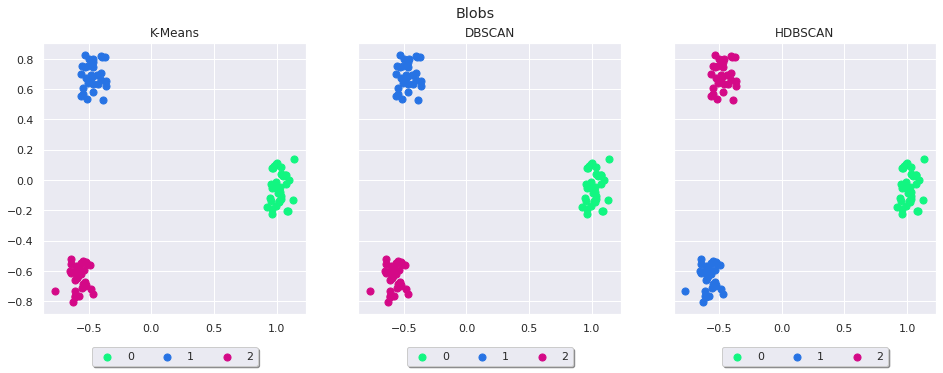

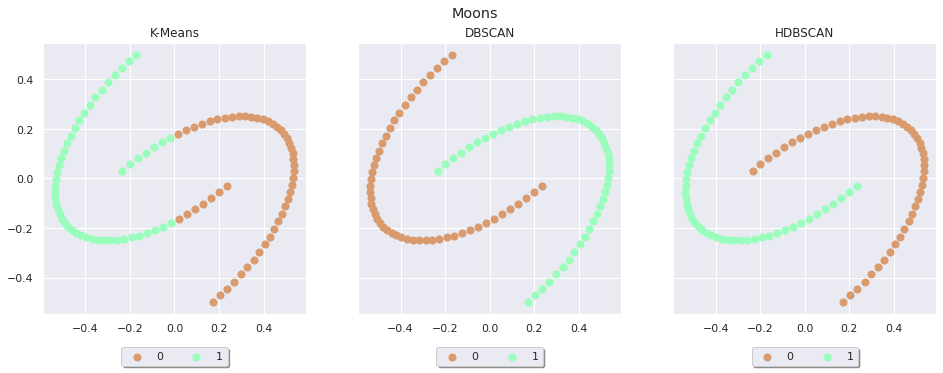

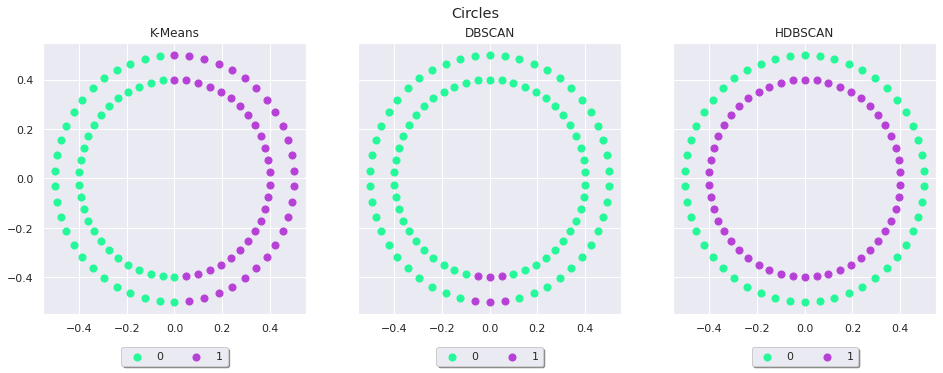

In [ ]:
metrics = ClusteringMetricsWrapper()

X = X_blobs
models = ClusteringModelsWrapper(n_clusters=3, eps=0.5)
kmeans_labels, dbscan_labels, hdbscan_labels = models.fit_predict(X)
cluster_plot(X, kmeans_labels, dbscan_labels, hdbscan_labels, title='Blobs')
print('K-Means ' + str(metrics.score(X,kmeans_labels)))
print('DBSCAN ' + str(metrics.score(X,dbscan_labels)))
print('HDBSCAN ' + str(metrics.score(X,hdbscan_labels)))

X = X_moons
models = ClusteringModelsWrapper(n_clusters=2, eps=0.1)
kmeans_labels, dbscan_labels, hdbscan_labels = models.fit_predict(X)
cluster_plot(X, kmeans_labels, dbscan_labels, hdbscan_labels, title='Moons')
print('K-Means ' + str(metrics.score(X,kmeans_labels)))
print('DBSCAN ' + str(metrics.score(X,dbscan_labels)))
print('HDBSCAN ' + str(metrics.score(X,hdbscan_labels)))

X = X_circles
models = ClusteringModelsWrapper(n_clusters=2, eps=0.1)
kmeans_labels, dbscan_labels, hdbscan_labels = models.fit_predict(X)
cluster_plot(X, kmeans_labels, dbscan_labels, hdbscan_labels, title='Circles')
print('K-Means ' + str(metrics.score(X,kmeans_labels)))
print('DBSCAN ' + str(metrics.score(X,dbscan_labels)))
print('HDBSCAN ' + str(metrics.score(X,hdbscan_labels)))

# CVI Analysis

- Datasets: Iris, Wine, Control;
- Sweep between number of clusters: 2-10;
- Clustering models: K-Means, DBSCAN, HDBSCAN;
- Clustering indexes: CH, CDbw, Dunn, DB, PBM, DBCV;

In [ ]:
X_iris = get_iris(dataset_for_clustering=True)
X_wine = get_wine(dataset_for_clustering=True)
X_ctrl = get_ctrl(dataset_for_clustering=True)

print('Iriss shape: ' + str(X_iris.shape))
print('Wine shape: ' + str(X_wine.shape))
print('Control shape: ' + str(X_ctrl.shape))

Iriss shape: (150, 4)
Wine shape: (178, 13)
Control shape: (600, 60)


## Generate labels

In [ ]:
kmeans_labels = []
dbscan_labels = []
hdbscan_labels = []

clusters = range(2,11)
for n_clusters in clusters:
  models = ClusteringModelsWrapper(n_clusters=n_clusters, eps=0.1, turn_model_on=[True,True,True])
  k, d, h = models.fit_predict(X_iris)
  kmeans_labels.append(k)
  dbscan_labels.append(d)
  hdbscan_labels.append(h)

pd.DataFrame(kmeans_labels).transpose().to_csv('kmeans_labels_iris.csv')
pd.DataFrame(dbscan_labels).transpose().to_csv('dbscan_labels_iris.csv')
pd.DataFrame(hdbscan_labels).transpose().to_csv('hdbscan_labels_iris.csv')

files.download('kmeans_labels_iris.csv')
files.download('dbscan_labels_iris.csv')
files.download('hdbscan_labels_iris.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
metrics = ClusteringMetricsWrapper()

kmeans_labels = []
dbscan_labels = []
hdbscan_labels = []

clusters = range(2,11)
for n_clusters in clusters:
  models = ClusteringModelsWrapper(n_clusters=n_clusters, eps=0.1, turn_model_on=[True,True,True])
  k, d, h = models.fit_predict(X_wine)
  kmeans_labels.append(k)
  dbscan_labels.append(d)
  hdbscan_labels.append(h)

pd.DataFrame(kmeans_labels).transpose().to_csv('kmeans_labels_wine.csv')
pd.DataFrame(dbscan_labels).transpose().to_csv('dbscan_labels_wine.csv')
pd.DataFrame(hdbscan_labels).transpose().to_csv('hdbscan_labels_wine.csv')

files.download('kmeans_labels_wine.csv')
files.download('dbscan_labels_wine.csv')
files.download('hdbscan_labels_wine.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
metrics = ClusteringMetricsWrapper()

kmeans_labels = []
dbscan_labels = []
hdbscan_labels = []

clusters = range(2,11)
for n_clusters in clusters:
  models = ClusteringModelsWrapper(n_clusters=n_clusters, eps=0.1, turn_model_on=[True,True,True])
  k, d, h = models.fit_predict(X_ctrl)
  kmeans_labels.append(k)
  dbscan_labels.append(d)
  hdbscan_labels.append(h)

pd.DataFrame(kmeans_labels).transpose().to_csv('kmeans_labels_ctrl.csv')
pd.DataFrame(dbscan_labels).transpose().to_csv('dbscan_labels_ctrl.csv')
pd.DataFrame(hdbscan_labels).transpose().to_csv('hdbscan_labels_ctrl.csv')

files.download('kmeans_labels_ctrl.csv')
files.download('dbscan_labels_ctrl.csv')
files.download('hdbscan_labels_ctrl.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Metrics evaluation (K-means)

In [3]:
!svn checkout https://github.com/Lwao/awesome-ai/trunk/ufrn-ai/datasets/cvi_analysis

Checked out revision 35.


In [4]:
names = np.array(range(1,11), dtype=str)
dbscan_labels_ctrl  = pd.read_csv('cvi_analysis/dbscan_labels_ctrl.csv',  names=names, header=0).drop("1",axis=1)
dbscan_labels_iris  = pd.read_csv('cvi_analysis/dbscan_labels_iris.csv',  names=names, header=0).drop("1",axis=1)
dbscan_labels_wine  = pd.read_csv('cvi_analysis/dbscan_labels_wine.csv',  names=names, header=0).drop("1",axis=1)
hdbscan_labels_ctrl = pd.read_csv('cvi_analysis/hdbscan_labels_ctrl.csv', names=names, header=0).drop("1",axis=1)
hdbscan_labels_iris = pd.read_csv('cvi_analysis/hdbscan_labels_iris.csv', names=names, header=0).drop("1",axis=1)
hdbscan_labels_wine = pd.read_csv('cvi_analysis/hdbscan_labels_wine.csv', names=names, header=0).drop("1",axis=1)
kmeans_labels_ctrl  = pd.read_csv('cvi_analysis/kmeans_labels_ctrl.csv',  names=names, header=0).drop("1",axis=1)
kmeans_labels_iris  = pd.read_csv('cvi_analysis/kmeans_labels_iris.csv',  names=names, header=0).drop("1",axis=1)
kmeans_labels_wine  = pd.read_csv('cvi_analysis/kmeans_labels_wine.csv',  names=names, header=0).drop("1",axis=1)

In [ ]:
metrics = ClusteringMetricsWrapper()

scores_iris_kmeans = pd.DataFrame()
scores_wine_kmeans = pd.DataFrame()
scores_ctrl_kmeans = pd.DataFrame()

for i in range(2,11):
  df_kmeans1 = pd.DataFrame.from_dict(metrics.score(X_iris,np.array(kmeans_labels_iris[str(i)])), orient='index').transpose()
  df_kmeans2 = pd.DataFrame.from_dict(metrics.score(X_wine,np.array(kmeans_labels_wine[str(i)])), orient='index').transpose()
  df_kmeans3 = pd.DataFrame.from_dict(metrics.score(X_ctrl,np.array(kmeans_labels_ctrl[str(i)])), orient='index').transpose()

  scores_iris_kmeans = pd.concat([scores_iris_kmeans,df_kmeans1], axis=0)
  scores_wine_kmeans = pd.concat([scores_wine_kmeans,df_kmeans2], axis=0)
  scores_ctrl_kmeans = pd.concat([scores_ctrl_kmeans,df_kmeans3], axis=0)

scores_iris_kmeans['clusters'] = range(2,11)
scores_wine_kmeans['clusters'] = range(2,11)
scores_ctrl_kmeans['clusters'] = range(2,11)

In [ ]:
scores_iris_kmeans.to_csv('scores_iris_kmeans.csv')
scores_wine_kmeans.to_csv('scores_wine_kmeans.csv')
scores_ctrl_kmeans.to_csv('scores_ctrl_kmeans.csv')

files.download('scores_iris_kmeans.csv')
files.download('scores_wine_kmeans.csv')
files.download('scores_ctrl_kmeans.csv')

In [5]:
!svn checkout https://github.com/Lwao/awesome-ai/trunk/ufrn-ai/datasets/cvi_analysis

Checked out revision 35.


In [6]:
scores_iris_kmeans = pd.read_csv('cvi_analysis/scores_iris_kmeans.csv', header=0).drop("Unnamed: 0",axis=1)
scores_wine_kmeans = pd.read_csv('cvi_analysis/scores_wine_kmeans.csv', header=0).drop("Unnamed: 0",axis=1)
scores_ctrl_kmeans = pd.read_csv('cvi_analysis/scores_ctrl_kmeans.csv', header=0).drop("Unnamed: 0",axis=1)

In [13]:
labels = list(df.columns)
labels.remove('clusters')
labels.remove('CDbw')
labels

['CH', 'Dunn', 'DB', 'PBM', 'DBCV']

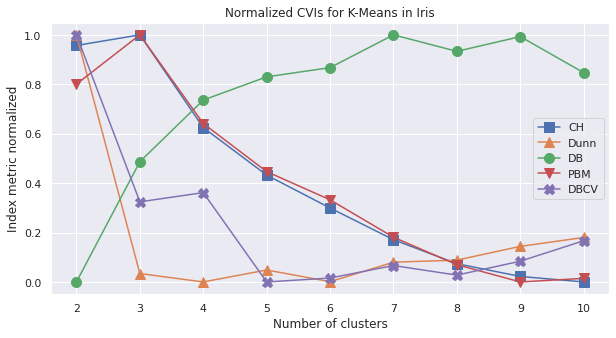

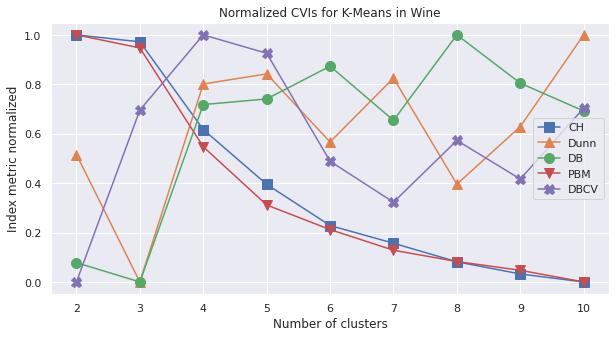

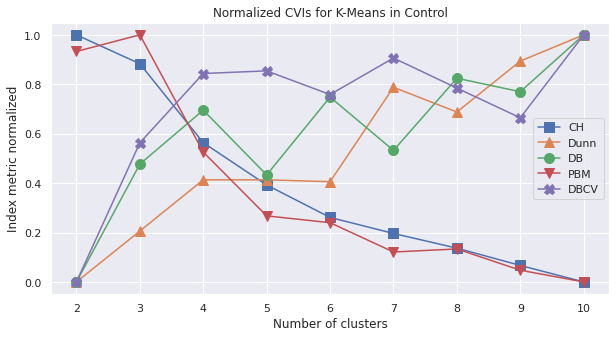

In [22]:
def plot_scores(df, title=''):
    labels = list(df.columns)
    labels.remove('clusters')
    labels.remove('CDbw')
    x = np.array(df['clusters'])
    Y = np.array(df.drop(columns=['clusters','CDbw']))
    max_ = np.max(Y, axis=0).reshape(1,-1)
    min_ = np.min(Y, axis=0).reshape(1,-1)
    Y = (Y-min_)/(max_-min_)
    markers = ['s','^','o','v','X']

    plt.figure(figsize=(10,5))
    for i in range(len(labels)): plt.plot(x, Y[:,i], label=labels[i], marker=markers[i], markersize=10) # marker='$'+labels[i]+'$'
    plt.legend()
    plt.title(title)
    plt.xlabel('Number of clusters')
    plt.ylabel('Index metric normalized');
    
plot_scores(scores_iris_kmeans, 'Normalized CVIs for K-Means in Iris')
plot_scores(scores_wine_kmeans, 'Normalized CVIs for K-Means in Wine')
plot_scores(scores_ctrl_kmeans, 'Normalized CVIs for K-Means in Control')

# Comparing cluster algorithms

- Datasets: Iris, Wine, Control;
- Clustering models: K-Means, DBSCAN, HDBSCAN;
- Clustering indexes: CH, CDbw, Dunn, DB, PBM, DBCV;

In [9]:
X_iris = get_iris(dataset_for_clustering=True)
X_wine = get_wine(dataset_for_clustering=True)
X_ctrl = get_ctrl(dataset_for_clustering=True)

print('Iriss shape: ' + str(X_iris.shape))
print('Wine shape: ' + str(X_wine.shape))
print('Control shape: ' + str(X_ctrl.shape))

Iriss shape: (150, 4)
Wine shape: (178, 13)
Control shape: (600, 60)


In [ ]:
metrics = ClusteringMetricsWrapper()

In [73]:
X = X_iris
models = ClusteringModelsWrapper(n_clusters=3, eps=0.1)
kmeans_labels, dbscan_labels, hdbscan_labels = models.fit_predict(X)
print('K-Means ' + str(metrics.score(X,kmeans_labels)))
print('DBSCAN ' + str(metrics.score(X,dbscan_labels)))
print('HDBSCAN ' + str(metrics.score(X,hdbscan_labels)))

K-Means {'CH': 358.5672171964303, 'CDbw': 0.0, 'Dunn': 0.06939133310888188, 'DB': 0.7609749366269764, 'PBM': 0.9456167239154767, 'DBCV': -0.2112098210904161}
DBSCAN {'CH': 61.875288170382724, 'CDbw': 0.0, 'Dunn': 0.016822910447760107, 'DB': 1.6527897182733622, 'PBM': 0.200215216639582, 'DBCV': -0.5435555544033094}
HDBSCAN {'CH': 353.3674032325119, 'CDbw': 0.0, 'Dunn': 0.3581116461764787, 'DB': 0.48770481288357487, 'PBM': 0.8280879530538743, 'DBCV': 0.4866851846920599}


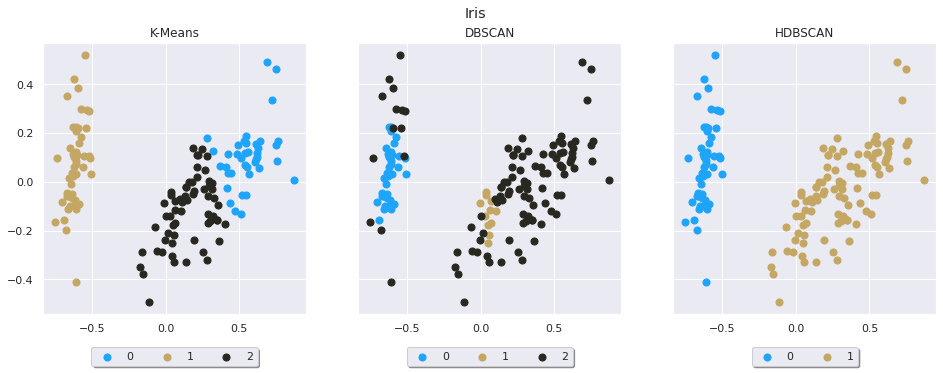

In [74]:
cluster_plot(X, kmeans_labels, dbscan_labels, hdbscan_labels, title='Iris')

In [75]:
X = X_wine
models = ClusteringModelsWrapper(n_clusters=3, eps=3)
kmeans_labels, dbscan_labels, hdbscan_labels = models.fit_predict(X)
print('K-Means ' + str(metrics.score(X,kmeans_labels)))
print('HDBSCAN ' + str(metrics.score(X,hdbscan_labels)))
print('DBSCAN ' + str(metrics.score(X,dbscan_labels)))

K-Means {'CH': 83.37374750844351, 'CDbw': 0.0, 'Dunn': 0.18933253049479679, 'DB': 1.305317989484142, 'PBM': 0.26445383800427347, 'DBCV': -0.45016899137652566}
HDBSCAN {'CH': 33.992754870493016, 'CDbw': 0.0, 'Dunn': 0.1262208579929579, 'DB': 2.828688315360727, 'PBM': 0.1412245130657737, 'DBCV': -0.21061676898526385}


ValueError: ignored

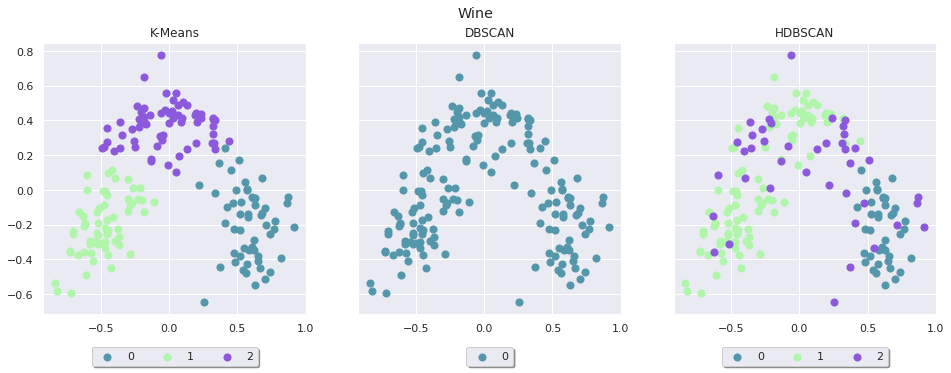

In [76]:
cluster_plot(X, kmeans_labels, dbscan_labels, hdbscan_labels, title='Wine')

In [90]:
X = X_ctrl
models = ClusteringModelsWrapper(n_clusters=3, eps=0.1)
kmeans_labels, dbscan_labels, hdbscan_labels = models.fit_predict(X)

print('K-Means ' + str(metrics.score(X,kmeans_labels)))
print('HDBSCAN ' + str(metrics.score(X,hdbscan_labels)))
print('DBSCAN ' + str(metrics.score(X,dbscan_labels)))

K-Means {'CH': 388.2965481525644, 'CDbw': 0.0, 'Dunn': 0.24906741265919002, 'DB': 1.3681933581408094, 'PBM': 2.2741053476692965, 'DBCV': -0.20696648546773078}


/usr/local/lib/python3.7/dist-packages/DBCV/DBCV.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  core_dist = (numerator / (n_neighbors)) ** (-1/n_features)


HDBSCAN {'CH': 23.952465983813227, 'CDbw': 0.0, 'Dunn': 0.21146790042873667, 'DB': 1.8989623395190982, 'PBM': 0.5817512506495797, 'DBCV': nan}


/usr/local/lib/python3.7/dist-packages/DBCV/DBCV.py:217: RuntimeWarning: invalid value encountered in double_scalars
  cluster_validity = numerator / denominator


ValueError: ignored

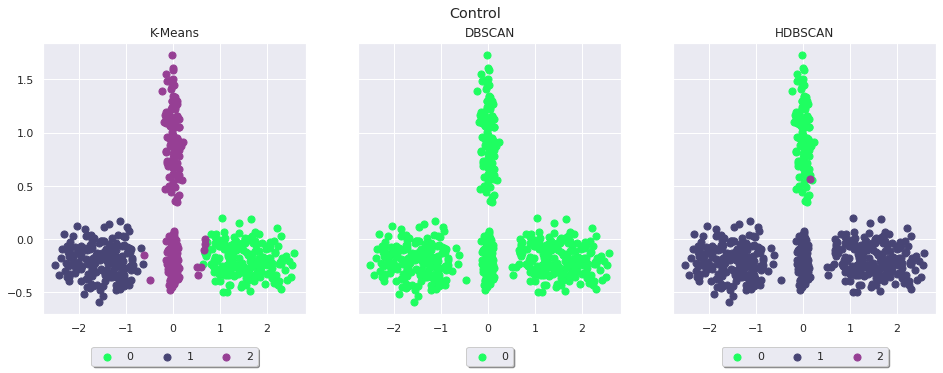

In [89]:
cluster_plot(X, kmeans_labels, dbscan_labels, hdbscan_labels, title='Control')